# **KELOMPOK 3**
- Muhammad Ilza Batistuta
- Mahesa Haryo Pamungkas
- Attila Kuncoro Djati
- Kevin Pratama

DATASET YANG DIGUNAKAN: **[District Wise Rainfall Normal – India](https://drive.google.com/file/d/1jtwp2SVDZAvxZiQk4NriGFsZOVNwks-O/view?usp=sharing)**
(berisi data curah hujan bulanan & tahunan dari distrik di India.)


## **SETUP**

In [ ]:
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Create output folder for P6 evidence
os.makedirs("/content/runs", exist_ok=True)

## **UPLOAD DATA**

In [ ]:
print("Upload your CSV file")
uploaded = files.upload()
if len(uploaded) == 0:
    raise RuntimeError("No file uploaded. Please upload a CSV file.")

DATA_FILE = list(uploaded.keys())[0]
DATA_PATH = f"/content/{DATA_FILE}"
df = pd.read_csv(DATA_PATH)

print("\n===== DATA PREVIEW =====")
display(df.head())

print("\n===== SHAPE =====")
print(df.shape)

print("\n===== COLUMNS =====")
print(df.columns.tolist())

print("\n===== MISSING VALUES (TOP) =====")
display(df.isna().sum().sort_values(ascending=False).head(20))

Upload your CSV file


Saving district wise rainfall normal.csv to district wise rainfall normal.csv

===== DATA PREVIEW =====


,STATE_UT_NAME,DISTRICT,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANNUAL,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
0,ANDAMAN And NICOBAR ISLANDS,NICOBAR,107.3,57.9,65.2,117.0,358.5,295.5,285.0,271.9,354.8,326.0,315.2,250.9,2805.2,165.2,540.7,1207.2,892.1
1,ANDAMAN And NICOBAR ISLANDS,SOUTH ANDAMAN,43.7,26.0,18.6,90.5,374.4,457.2,421.3,423.1,455.6,301.2,275.8,128.3,3015.7,69.7,483.5,1757.2,705.3
2,ANDAMAN And NICOBAR ISLANDS,N & M ANDAMAN,32.7,15.9,8.6,53.4,343.6,503.3,465.4,460.9,454.8,276.1,198.6,100.0,2913.3,48.6,405.6,1884.4,574.7
3,ARUNACHAL PRADESH,LOHIT,42.2,80.8,176.4,358.5,306.4,447.0,660.1,427.8,313.6,167.1,34.1,29.8,3043.8,123.0,841.3,1848.5,231.0
4,ARUNACHAL PRADESH,EAST SIANG,33.3,79.5,105.9,216.5,323.0,738.3,990.9,711.2,568.0,206.9,29.5,31.7,4034.7,112.8,645.4,3008.4,268.1



===== SHAPE =====
(641, 19)

===== COLUMNS =====
['STATE_UT_NAME', 'DISTRICT', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'ANNUAL', 'Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']

===== MISSING VALUES (TOP) =====


,0
STATE_UT_NAME,0
DISTRICT,0
JAN,0
FEB,0
MAR,0
APR,0
MAY,0
JUN,0
JUL,0
AUG,0


## **DATA CLEANING**


*   drop unnecessary seasonal columns
*   ensure ANNUAL exists
*   handle missing values


In [ ]:
cols_to_drop = ["Jan-Feb", "Mar-May", "Jun-Sep", "Oct-Dec"]
df = df.drop(columns=cols_to_drop, errors="ignore")

# Normalize annual column name
if "Annual" in df.columns and "ANNUAL" not in df.columns:
    df.rename(columns={"Annual": "ANNUAL"}, inplace=True)

if "ANNUAL" not in df.columns:
    raise ValueError("Column ANNUAL not found. Check your dataset column name.")

# Drop rows with missing target
df = df.dropna(subset=["ANNUAL"]).copy()

# For simplicity and reproducibility in UAS report:
# drop remaining missing (you can replace with imputation and explain in report)
df = df.dropna().copy()

print("\n===== AFTER CLEANING =====")
print("Shape:", df.shape)
print(df["ANNUAL"].describe())


===== AFTER CLEANING =====
Shape: (641, 15)
count     641.000000
mean     1346.969579
std       838.878874
min        94.600000
25%       830.400000
50%      1116.200000
75%      1530.900000
max      7229.300000
Name: ANNUAL, dtype: float64


## **IMD 4-CLASS LABELING**


===== LABEL DISTRIBUTION =====
Label_IMD_4Class
0     33
1    228
2    274
3    106
Name: count, dtype: int64


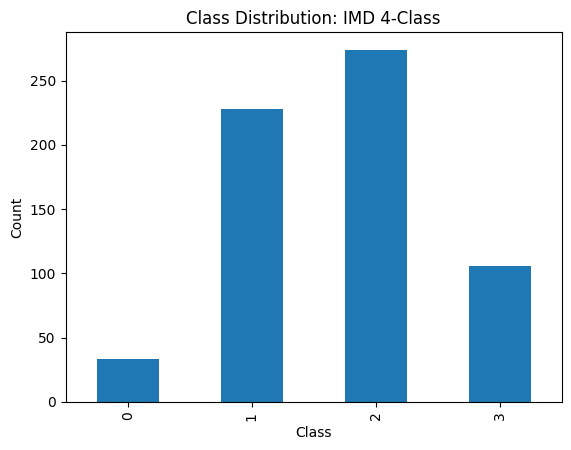

In [ ]:
def label_imd_4class(value):
    if value < 500:
        return 0   # Arid
    elif value < 1000:
        return 1   # Semi-Arid
    elif value < 2000:
        return 2   # Humid
    else:
        return 3   # Very Humid

df["Label_IMD_4Class"] = df["ANNUAL"].apply(label_imd_4class).astype(int)

print("\n===== LABEL DISTRIBUTION =====")
class_dist = df["Label_IMD_4Class"].value_counts().sort_index()
print(class_dist)

plt.figure()
class_dist.plot(kind="bar")
plt.title("Class Distribution: IMD 4-Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## **FEATURE SELECTION + PREPROCESSING**

In [ ]:
X = df.drop(["ANNUAL", "Label_IMD_4Class"], axis=1)
y = df["Label_IMD_4Class"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()

print("\n===== FEATURE TYPES =====")
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
    remainder="drop"
)


===== FEATURE TYPES =====
Numeric cols: ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
Categorical cols: ['STATE_UT_NAME', 'DISTRICT']


## **TRAIN-TEST SPLIT**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

X_train_p = preprocessor.fit_transform(X_train)
X_test_p = preprocessor.transform(X_test)

num_features = X_train_p.shape[1]
print("\nProcessed feature dimension:", num_features)


Processed feature dimension: 554


## **HELPERS: callbacks, model builder, training, evaluation**

In [ ]:

def get_callbacks():
    return [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5
        )
    ]

def build_mlp(num_features, activation="relu", dropout=0.3, lr=1e-3, optimizer_name="adam"):
    model = models.Sequential()
    model.add(layers.Input(shape=(num_features,)))

    if activation.lower() == "leakyrelu":
        model.add(layers.Dense(64))
        model.add(layers.LeakyReLU(alpha=0.1))
        model.add(layers.Dense(32))
        model.add(layers.LeakyReLU(alpha=0.1))
        model.add(layers.Dropout(dropout))
        model.add(layers.Dense(16))
        model.add(layers.LeakyReLU(alpha=0.1))
    else:
        model.add(layers.Dense(64, activation=activation))
        model.add(layers.Dense(32, activation=activation))
        model.add(layers.Dropout(dropout))
        model.add(layers.Dense(16, activation=activation))

    model.add(layers.Dense(4, activation="softmax"))

    if optimizer_name.lower() == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name.lower() == "sgd":
        opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0)
    elif optimizer_name.lower() == "sgd_momentum":
        opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    else:
        raise ValueError("optimizer_name must be: adam, sgd, sgd_momentum")

    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def plot_history(history, title):
    plt.figure()
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def evaluate(model, X_test_p, y_test, title):
    loss, acc = model.evaluate(X_test_p, y_test, verbose=0)
    y_prob = model.predict(X_test_p, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    cm = confusion_matrix(y_test, y_pred)

    print(f"\n===== {title} TEST =====")
    print("Test Loss:", loss)
    print("Test Accuracy:", acc)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.colorbar()
    plt.xticks(np.arange(4))
    plt.yticks(np.arange(4))
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.show()

    return {
        "test_loss": float(loss),
        "test_accuracy": float(acc),
        "confusion_matrix": cm.tolist()
    }

def run_experiment(cfg):
    run_name = cfg["run_name"]
    print(f"\n================ RUN: {run_name} ================")

    model = build_mlp(
        num_features=num_features,
        activation=cfg["activation"],
        dropout=cfg["dropout"],
        lr=cfg["lr"],
        optimizer_name=cfg["optimizer"]
    )

    start = time.time()
    history = model.fit(
        X_train_p, y_train,
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        validation_split=0.2,
        callbacks=get_callbacks(),
        verbose=1
    )
    elapsed = time.time() - start

    plot_history(history, run_name)
    metrics = evaluate(model, X_test_p, y_test, run_name)

    result_row = {
        **cfg,
        "train_time_sec": float(elapsed),
        "best_val_accuracy": float(np.max(history.history["val_accuracy"])),
        "best_val_loss": float(np.min(history.history["val_loss"])),
        "test_accuracy": metrics["test_accuracy"],
        "test_loss": metrics["test_loss"],
    }
    return model, history, metrics, result_row

## **BASELINE (Model Dasar)**
Artificial Neural Network (ANN) dengan arsitektur Feedforward Neural Network (FNN / Multilayer Perceptron)


================ RUN: exp01_baseline_adam_relu_lr1e-3_bs16 ================
Epoch 1/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4405 - loss: 1.3257 - val_accuracy: 0.6602 - val_loss: 1.1107 - learning_rate: 0.0010
Epoch 2/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6670 - loss: 1.0670 - val_accuracy: 0.7767 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch 3/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7824 - loss: 0.8072 - val_accuracy: 0.8641 - val_loss: 0.6028 - learning_rate: 0.0010
Epoch 4/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8628 - loss: 0.5629 - val_accuracy: 0.8738 - val_loss: 0.4402 - learning_rate: 0.0010
Epoch 5/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8985 - loss: 0.4237 - val_accuracy: 0.9029 - val_loss: 0.3437 - learning_rate: 0.0010
Epoch 6/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9040 - loss: 0.3396 - val_accuracy: 0.9126 - val_loss: 0.2757 - learning_rate: 0.0010
Epoch 7/70
26/26 ━━━━━

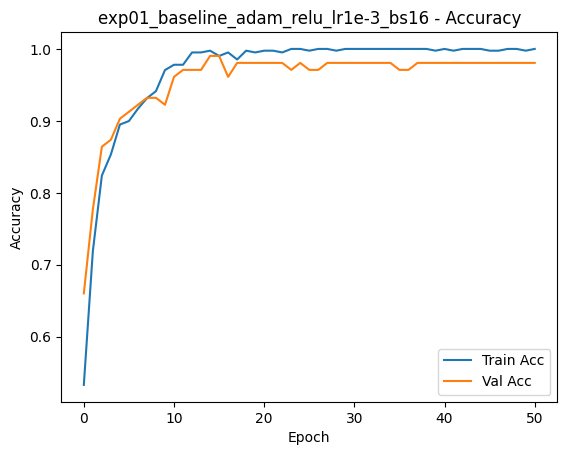

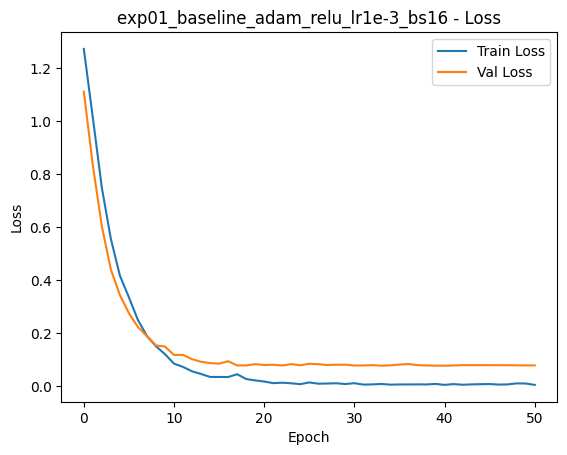


===== exp01_baseline_adam_relu_lr1e-3_bs16 TEST =====
Test Loss: 0.19760748744010925
Test Accuracy: 0.9224806427955627

Classification Report:
              precision    recall  f1-score   support

           0     0.7500    0.8571    0.8000         7
           1     0.8958    0.9348    0.9149        46
           2     0.9615    0.9091    0.9346        55
           3     0.9524    0.9524    0.9524        21

    accuracy                         0.9225       129
   macro avg     0.8899    0.9133    0.9005       129
weighted avg     0.9251    0.9225    0.9232       129



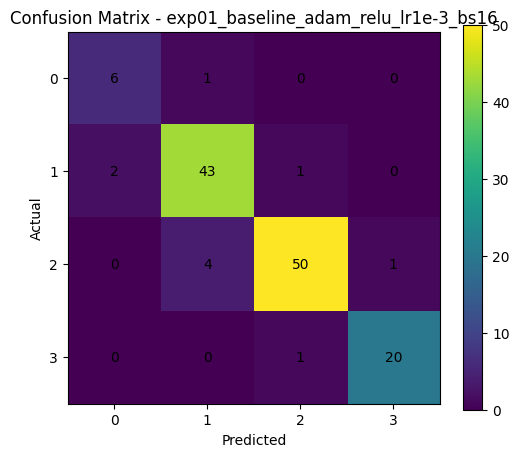

In [ ]:
BASELINE = {
    "run_name": "exp01_baseline_adam_relu_lr1e-3_bs16",
    "optimizer": "adam",
    "activation": "relu",
    "lr": 1e-3,
    "batch_size": 16,
    "epochs": 70,
    "dropout": 0.3
}

baseline_model, baseline_hist, baseline_metrics, baseline_row = run_experiment(BASELINE)

## **EXPERIMENT**


*   Optimizer comparison: SGD vs Adam
*   Activation comparison: LeakyReLU vs ReLU




================ RUN: exp02_sgd_relu_lr1e-2_bs16 ================
Epoch 1/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.1733 - loss: 1.3841 - val_accuracy: 0.4175 - val_loss: 1.3391 - learning_rate: 0.0100
Epoch 2/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4376 - loss: 1.3139 - val_accuracy: 0.5437 - val_loss: 1.2604 - learning_rate: 0.0100
Epoch 3/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5734 - loss: 1.2311 - val_accuracy: 0.5922 - val_loss: 1.1806 - learning_rate: 0.0100
Epoch 4/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6109 - loss: 1.1553 - val_accuracy: 0.6117 - val_loss: 1.1104 - learning_rate: 0.0100
Epoch 5/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6349 - loss: 1.0799 - val_accuracy: 0.6311 - val_loss: 1.0474 - learning_rate: 0.0100
Epoch 6/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6485 - loss: 1.0383 - val_accuracy: 0.6505 - val_loss: 0.9955 - learning_rate: 0.0100
Epoch 7/70
26/26 ━━━━━━━━━━

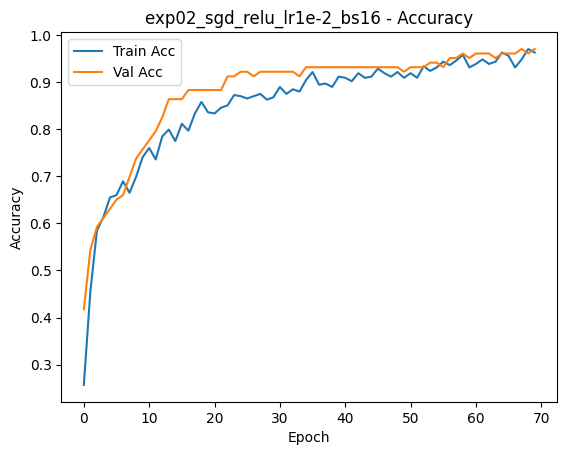

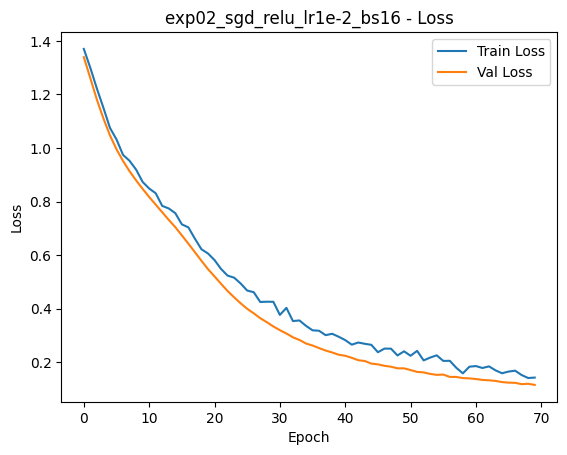


===== exp02_sgd_relu_lr1e-2_bs16 TEST =====
Test Loss: 0.19658976793289185
Test Accuracy: 0.9069767594337463

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.2857    0.4444         7
           1     0.8302    0.9565    0.8889        46
           2     0.9615    0.9091    0.9346        55
           3     0.9545    1.0000    0.9767        21

    accuracy                         0.9070       129
   macro avg     0.9366    0.7878    0.8112       129
weighted avg     0.9156    0.9070    0.8986       129



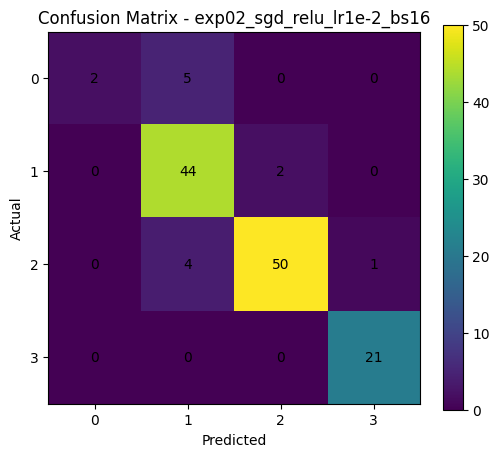

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(



================ RUN: exp03_adam_leakyrelu_lr1e-3_bs16 ================
Epoch 1/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5436 - loss: 1.2835 - val_accuracy: 0.7573 - val_loss: 1.0522 - learning_rate: 0.0010
Epoch 2/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7833 - loss: 0.9751 - val_accuracy: 0.8350 - val_loss: 0.7419 - learning_rate: 0.0010
Epoch 3/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8248 - loss: 0.6655 - val_accuracy: 0.8738 - val_loss: 0.5350 - learning_rate: 0.0010
Epoch 4/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8661 - loss: 0.4923 - val_accuracy: 0.9029 - val_loss: 0.4235 - learning_rate: 0.0010
Epoch 5/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8906 - loss: 0.3541 - val_accuracy: 0.9029 - val_loss: 0.3394 - learning_rate: 0.0010
Epoch 6/70
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9297 - loss: 0.2573 - val_accuracy: 0.9126 - val_loss: 0.2719 - learning_rate: 0.0010
Epoch 7/70
26/26 ━━━━━

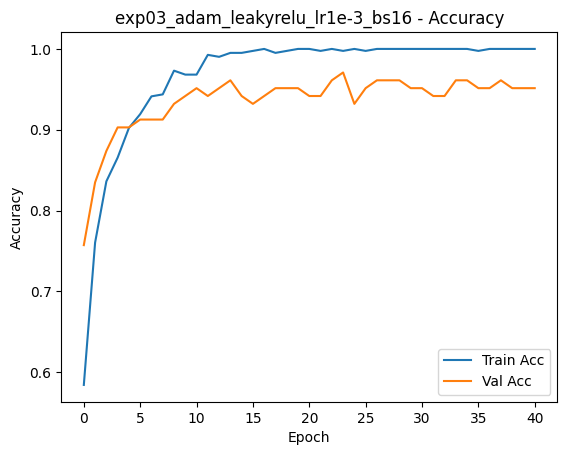

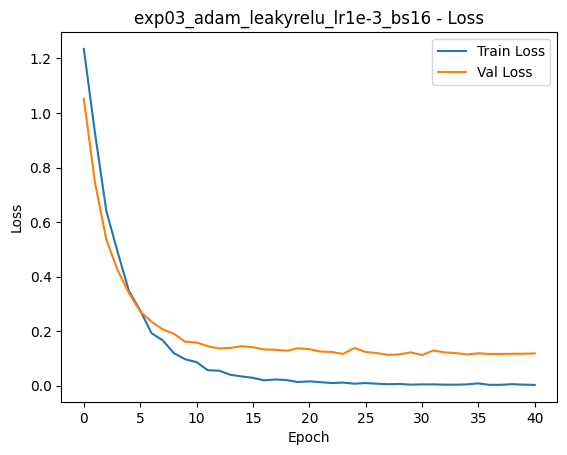


===== exp03_adam_leakyrelu_lr1e-3_bs16 TEST =====
Test Loss: 0.23225340247154236
Test Accuracy: 0.8992248177528381

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.8571    0.9231         7
           1     0.8958    0.9348    0.9149        46
           2     0.9057    0.8727    0.8889        55
           3     0.8636    0.9048    0.8837        21

    accuracy                         0.8992       129
   macro avg     0.9163    0.8924    0.9026       129
weighted avg     0.9004    0.8992    0.8992       129



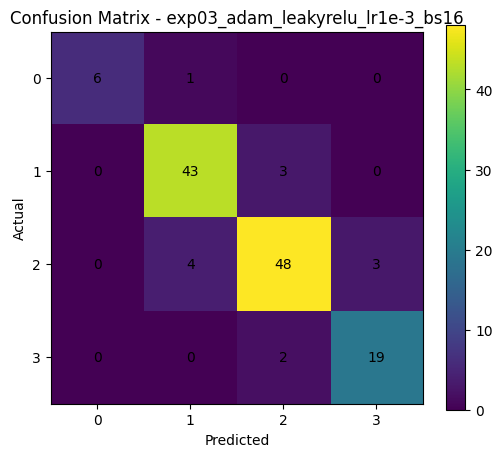


===== EXPERIMENT SUMMARY TABLE (P4) =====


,run_name,optimizer,activation,lr,batch_size,best_val_accuracy,best_val_loss,test_accuracy,test_loss,train_time_sec
0,exp01_baseline_adam_relu_lr1e-3_bs16,adam,relu,0.001,16,0.990291,0.078023,0.922481,0.197607,21.827099
1,exp02_sgd_relu_lr1e-2_bs16,sgd,relu,0.010,16,0.970874,0.115669,0.906977,0.196590,21.431379
2,exp03_adam_leakyrelu_lr1e-3_bs16,adam,leakyrelu,0.001,16,0.970874,0.112035,0.899225,0.232253,14.173413


In [ ]:
EXPERIMENTS = [
    {
        "run_name": "exp02_sgd_relu_lr1e-2_bs16",
        "optimizer": "sgd",
        "activation": "relu",
        "lr": 1e-2,          # often higher for SGD
        "batch_size": 16,
        "epochs": 70,
        "dropout": 0.3
    },
    {
        "run_name": "exp03_adam_leakyrelu_lr1e-3_bs16",
        "optimizer": "adam",
        "activation": "leakyrelu",
        "lr": 1e-3,
        "batch_size": 16,
        "epochs": 70,
        "dropout": 0.3
    }
]

all_rows = [baseline_row]
models_map = {BASELINE["run_name"]: baseline_model}

for cfg in EXPERIMENTS:
    m, h, met, row = run_experiment(cfg)
    all_rows.append(row)
    models_map[cfg["run_name"]] = m

# Summary table (P4)
results_df = pd.DataFrame(all_rows).sort_values("test_accuracy", ascending=False)
print("\n===== EXPERIMENT SUMMARY TABLE (P4) =====")
display(results_df[[
    "run_name", "optimizer", "activation", "lr", "batch_size",
    "best_val_accuracy", "best_val_loss", "test_accuracy", "test_loss", "train_time_sec"
]])